# Combine DIC data with X-ray in order to calculate multiaxial flow curve

- Use pylab inline

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


- Dependents

In [2]:
import os, time
from MP.mat import mech
from glob import glob
import RS
reload(RS)
from RS import sfig_class
reload(sfig_class)

from RS import analyze_proto,sff_plot
import matplotlib as mpl
from MP import progress_bar, lib
from MP import mat
mech=mat.mech

mpl_lib=lib.mpl_lib
uet=progress_bar.update_elapsed_time
GS=mpl.gridspec.GridSpec
fc=mat.mech.FlowCurve

- Name of DIC files

In [3]:
date='20120711'
path='/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/BB/'
fn_DIC=os.path.join(path,date,'DIC/DIC_results.txt')
dic_dat=np.loadtxt(fn_DIC,skiprows=1).T

# Read lab note book in order to match Xray file and DIC index

In [4]:
print os.popen('ls -ls %s'%os.path.join(path,date,'Xray')).read()

total 800
8 -rw-------  1 yj  admin  1446 Mar 30 15:44 11JUL12_0007Data.txt
8 -rw-------  1 yj  admin  2982 Mar 30 15:44 11JUL12_0007Data1Phi-90.txt
8 -rw-------  1 yj  admin  2979 Mar 30 15:44 11JUL12_0007Data2Phi0.txt
8 -rw-------  1 yj  admin  2980 Mar 30 15:44 11JUL12_0007Data3Phi45.txt
8 -rw-------  1 yj  admin  2982 Mar 30 15:44 11JUL12_0007Data4Phi135.txt
8 -rw-------  1 yj  admin  1447 Mar 30 15:44 11JUL12_0008Data.txt
8 -rw-------  1 yj  admin  2982 Mar 30 15:44 11JUL12_0008Data1Phi-90.txt
8 -rw-------  1 yj  admin  2980 Mar 30 15:44 11JUL12_0008Data2Phi0.txt
8 -rw-------  1 yj  admin  2981 Mar 30 15:44 11JUL12_0008Data3Phi45.txt
8 -rw-------  1 yj  admin  2982 Mar 30 15:44 11JUL12_0008Data4Phi135.txt
8 -rw-------  1 yj  admin  1447 Mar 30 15:44 11JUL12_0009Data.txt
8 -rw-------  1 yj  admin  2982 Mar 30 15:44 11JUL12_0009Data1Phi-90.txt
8 -rw-------  1 yj  admin  2980 Mar 30 15:44 11JUL12_0009Data2Phi0.txt
8 -rw-------  1 yj  admin  2981 Mar 30 15:44 11JUL12_0009Data3Phi45.tx

- Making a fref file for Proto data analysis

In [5]:
# ------------------------------------------------------------------------
# Find suitable experimental stress factor file
#fn_sff='/Users/yj/GoogleDrive/expdat/Marciniak-X-ray-IF/YJ_BB_10times.sff'
fn_sff='/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/YJ_BB_10times.sff'

# ------------------------------------------------------------------------
# Refer to Laboratory notebook to match up the X-ray data filename 
# and DIC image number
DIC_XRD="""#8  11JUL12_0007.tr
#9   11JUL12_0007.tr
#67  11JUL12_0008.tr
#68  11JUL12_0008.tr
#91  11JUL12_0009.tr
#92  11JUL12_0009.tr
#108 11JUL12_0010.tr
#109 11JUL12_0010.tr
#124 11JUL12_0011.tr
#125 11JUL12_0011.tr
#139 11JUL12_0012.tr
#140 11JUL12_0012.tr
#154 11JUL12_0013.tr
#155 11JUL12_0013.tr
#168 11JUL12_0014.tr
#169 11JUL12_0014.tr
#181 11JUL12_0015.tr
#182 11JUL12_0015.tr
#193 11JUL12_0016.tr
#194 11JUL12_0016.tr
#206 11JUL12_0017.tr
#218 12JUL12_0001.tr
#219 12JUL12_0001.tr
#228 12JUL12_0002.tr
#229 12JUL12_0002.tr
#238 12JUL12_0003.tr
#239 12JUL12_0003.tr
#247 12JUL12_0004.tr
#248 12JUL12_0004.tr
#255 12JUL12_0005.tr
#256 12JUL12_0005.tr
#319 12JUL12_0006.tr
#320 12JUL12_0006.tr
#366 12JUL12_0007.tr
#456 12JUL12_0008.tr
#457 12JUL12_0008.tr
#490 12JUL12_0009.tr"""
# ------------------------------------------------------------------------

In [6]:
fn_fref=fn_DIC.split('DIC')[0]+'f_fref.txt'
f_fref=open(fn_fref,'w')

f_fref.write(fn_sff)
f_fref.write('  MajorStrainColumn: 2\n')
f_fref.write(('%14s'+'%12s '*4+' %5s'+'%12s '*4+' %14s\n')%(
        'filename','Exx','Eyy','Exy','Ezz','DIC','Exx_e','Eyye','SIG_a','SIG_e','Date'))
lines=DIC_XRD.split('\n')
inds = []; fns = []
## flow curve obj
myfc=fc()
Ex,Ey,Exy,Ez=[],[],[],[]

Ex_std =[]
Ey_std =[]
DIC_sigma_avg=[]; DIC_sigma_std=[]

for line in lines:
    ind,fn=line.split()
    ind=int(ind.split('#')[-1])
    fn = fn.split('.tr')[0]
    inds.append(ind); fns.append(fn)
    
    col = dic_dat[0]
    ix=np.where(col==ind)[0]
    i = int(col[ix][0]) ## dic index
    # print ix,i

    exx = dic_dat[5][ix]
    eyy = dic_dat[7][ix]
    exy = dic_dat[9][ix]
    ezz = -exx-eyy    
    
    # -----------------------------------------
    """ Additional elements..."""
    exx_std       = dic_dat[6][ix]
    eyy_std       = dic_dat[8][ix]
    DIC_sigma_a   = dic_dat[11][ix]
    DIC_sigma_e   = dic_dat[12][ix]
    # -----------------------------------------

    f_fref.write(('%14s '+'%+11.5e '*4+'%5i '+'%+11.5e '*4+' %14s\n')%(
            fn, exx, eyy, exy, ezz,i,exx_std,eyy_std,DIC_sigma_a,DIC_sigma_e,date))
    
    Ex.append(exx);Ey.append(eyy);Exy.append(exy);Ez.append(ezz)
    Ex_std.append(exx_std)
    Ey_std.append(eyy_std)
    DIC_sigma_avg.append(DIC_sigma_a)
    DIC_sigma_std.append(DIC_sigma_e)

myfc.get_strain(Ex,0,0)
myfc.get_strain(Ey,1,1)
myfc.get_strain(Exy,0,1)
myfc.get_strain(Exy,1,0)
myfc.get_strain(Ez,2,2)
myfc.set_zero_epsilon_ij(2,1)
myfc.set_zero_epsilon_ij(0,2)
myfc.get_vm_strain()
myfc.get_vm_stress()

myfc.DIC_sigma_avg=DIC_sigma_avg
myfc.DIC_sigma_std=DIC_sigma_std
myfc.Ex_std=Ex_std
myfc.Ey_std=Ey_std

f_fref.close()
print '-'*50
print fn_fref, 'has been created:\n Use it for further stress analysis'
print '-'*50

--------------------------------------------------
/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/BB/20120711/f_fref.txt has been created:
 Use it for further stress analysis
--------------------------------------------------


In [7]:
print os.popen('head -n 5 %s'%os.path.join(path,date,'f_fref.txt')).read()

/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/YJ_BB_10times.sff  MajorStrainColumn: 2
      filename         Exx          Eyy          Exy          Ezz    DIC       Exx_e         Eyye        SIG_a        SIG_e            Date
  11JUL12_0007 +2.13396e-05 -2.79467e-05 -3.65943e-05 +6.60710e-06     8 +5.73920e-04 +3.27186e-04 +6.94322e-03 +6.24474e-04        20120711
  11JUL12_0007 +4.40269e-05 +2.79777e-05 -4.96338e-05 -7.20046e-05     9 +6.47238e-04 +3.53236e-04 +7.15362e-03 +7.26685e-04        20120711
  11JUL12_0008 +4.69176e-03 +4.50139e-03 -8.48621e-05 -9.19315e-03    67 +7.49614e-04 +4.05593e-04 +7.18954e-03 +6.71936e-04        20120711



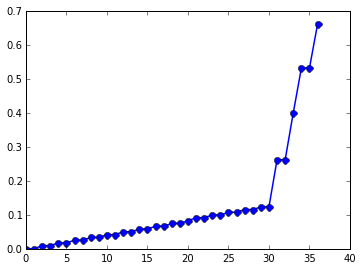

In [8]:
#plot(myfc.epsilon[0,0],myfc.epsilon[1,1],'x')
plot(myfc.epsilon_vm,'-o')

+ Running analyze_proto.main for the X-ray and DIC experiments to calculate
  stress/strain

In [9]:
## plastic strain of the points where the X-ray d-spacing
## were meausured are important information that is utilized over the X ray analysis.
## If, fc or fn_str are not given, the below application
## bases on the strain given in the fref file -
## the two major strain components are used with assumption
## that the sample was in 'equi-biaxial' strain.
t0=time.time()
RS=analyze_proto.main(path=os.path.join(path,date,'Xray'),
                   fn_sf=fn_sff,fref=os.path.join(path,date,'f_fref.txt'),
                   ind_plot=True)
uet(time.time()-t0)

---------------------------------------------
Strain information where SF/IG were measured
requires either fc or fn_str specified
If not the strain column in fn_sf is used,
subsequent analysis is performed by assuming
that the sample is in equibiaxial strain
---------------------------------------------


#-----------------------------------------------------#
 Interpolate SF and IG for matching with D-spacings
epsilon_vm:
[  2.92124441e-05   7.25983565e-05   9.19380700e-03   9.23668370e-03
   1.75470716e-02   1.73346909e-02   2.55492605e-02   2.53548294e-02
   3.36904110e-02   3.36460070e-02   4.17516018e-02   4.17588315e-02
   4.99921396e-02   5.00162687e-02   5.82765416e-02   5.84460279e-02
   6.64967713e-02   6.65174200e-02   7.47106402e-02   7.47305164e-02
   8.28105096e-02   9.15743574e-02   9.16455016e-02   9.96240820e-02
   9.97358355e-02   1.07664250e-01   1.07700992e-01   1.15500929e-01
   1.15513437e-01   1.23293563e-01   1.23662518e-01   2.62159489e-01
   2.62345624e-01   4

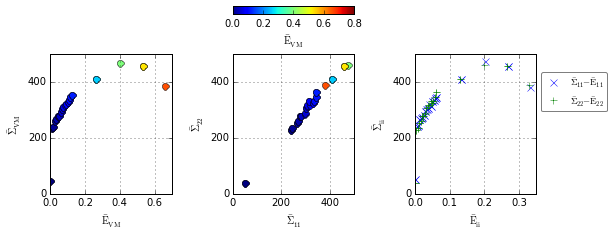

In [10]:
""" 
RS.EXP.flow.epsilon, RS.flow.sigma
"""
mn=0;mx=0.8
norm = mpl.colors.Normalize(vmin=mn,vmax=mx)
cmap, m = mpl_lib.norm_cmap(mn=mn,mx=mx)

fx=9
fy=fx*0.35
fig=plt.figure(figsize=(fx,fy))
gs=GS(20,3,wspace=0.5)
ax1=fig.add_subplot(gs[5:,0])
ax2=fig.add_subplot(gs[5:,1])
ax3=fig.add_subplot(gs[5:,2])

nstp = RS.EXP.flow.nstp


for istp in xrange(nstp):
    c=m.to_rgba(RS.EXP.flow.epsilon_vm[istp])
    ax2.plot(RS.flow.sigma[0,0][istp],RS.flow.sigma[1,1][istp],
             'o',mec='k',mfc=c)
    ax1.plot(RS.EXP.flow.epsilon_vm[istp],RS.flow.sigma_vm[istp],'o',c=c)
# ax2.plot(RS.flow.sigma[0,0],RS.flow.sigma[1,1],'k--')

ax3.plot(RS.EXP.flow.epsilon[0,0],RS.flow.sigma[0,0],'x',label=r'$\mathrm{\bar{\Sigma}_{11} - \bar{E}_{11}}$')
ax3.plot(RS.EXP.flow.epsilon[1,1],RS.flow.sigma[1,1],'+',label=r'$\mathrm{\bar{\Sigma}_{22} - \bar{E}_{22}}$')


for ax in fig.axes:
    ax.set_ylim(0.,);ax.set_xlim(0.,)
    ax.locator_params(nbins=4)
    ax.grid()

ax2.set_xlabel(r'$\mathrm{\bar{\Sigma}_{11}}$')
ax2.set_ylabel(r'$\mathrm{\bar{\Sigma}_{22}}$')
ax3.set_xlabel(r'$\mathrm{\bar{E}_{ii}}$')
ax3.set_ylabel(r'$\mathrm{\bar{\Sigma}_{ii}}$')
ax1.set_xlabel(r'$\mathrm{\bar{E}_{VM}}$')
ax1.set_ylabel(r'$\mathrm{\bar{\Sigma}_{VM}}$')
ax3.legend(loc='best',fontsize=9,numpoints=1,bbox_to_anchor=(1,0.9))


axcb=fig.add_subplot(gs[0,1])
cb=mpl.colorbar.ColorbarBase(axcb,cmap=cmap,orientation='horizontal',
                          norm=norm,filled=True,format='%3.1f')
# axcb.locator_params(nbins=4)
axcb.set_xlabel(r'$\mathrm{\bar{E}_{VM}}$')
cb.set_ticks(np.linspace(mn,mx,5))

- Pickle the object 'RS' and save to a file

In [11]:
import cPickle as pickle
def save_object(obj, filename):
    with open(filename, 'wb') as output:
        pickle.dump(obj, output, pickle.HIGHEST_PROTOCOL)

fn = os.path.join(path,date,'RS.pck')
print fn
save_object(obj=RS, filename=fn)

fn = os.path.join('../../../pickles/RS_%s.pck'%date)
print os.path.join(os.getcwd(),fn)
save_object(obj=RS, filename=fn)


fn = os.path.join('../../../pickles/RS_DIC_%s.pck'%date)
print os.path.join(os.getcwd(),fn)
save_object(obj=myfc, filename=fn)

/Users/yj/Documents/ExpDat/IFSteel/Marciniak-X-ray-IF/BB/20120711/RS.pck
/Users/yj/repo/FLD_DIC_XRAY/tutorials/XRD_analysis/IF_steel/BB/../../../pickles/RS_20120711.pck
/Users/yj/repo/FLD_DIC_XRAY/tutorials/XRD_analysis/IF_steel/BB/../../../pickles/RS_DIC_20120711.pck
